In [1]:
%matplotlib inline
import matplotlib.pyplot as mplt
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt 
from utils import *
from plotting import *
import plotly as plt
import plotly.graph_objects as go
from plotly.colors import n_colors
plt.offline.init_notebook_mode()
plt.io.templates.default = "none"
print(theano.config.device)

np.random.seed(42)
pm.set_tt_rng(42)


Loaded configuration file /lila/home/harrigan/.local/share/jupyter/runtime/kernel-c8741ad6-328c-4774-ba92-a05a5c0af5bd.json


cpu


Generate Data

In [2]:
def sim_parametric(J,K,N,S,alpha_bias,psi_bias,gamma_bias,beta_bias,seed):
    np.random.seed(seed)
    N = np.array([N] * S)

    # Hyper-parameter for priors
    alpha = np.ones(C) * alpha_bias
    psi = np.ones(J) * psi_bias
    gamma = np.ones(K) * gamma_bias
    beta = np.ones((K,4)) * beta_bias
    
    phi = pm.Dirichlet.dist(a=alpha, shape=(C)).random(size = J)
    theta = pm.Dirichlet.dist(a=psi).random(size = S)
    A = pm.Dirichlet.dist(a=gamma, shape=(J, K)).random(size = S)
    # ACGT
    # 0123
    eta = np.vstack([[pm.Dirichlet.dist(a=beta[:,[0,2,3]]).random(size=1)] , 
                         [pm.Dirichlet.dist(a=beta[:,[0,1,2]]).random(size=1)] ]).squeeze()

    W=np.dot(theta, phi).reshape(S,2,16)
    Q=np.einsum('sj,sjk,pkm->spm', theta, A, eta)
    B=np.einsum('spc,spm->spmc', W, Q).reshape(S, -1)
    
    data = np.vstack([d.random(size = 1) for d in map(pm.Multinomial.dist, N, B)])
    return data, {'phi': phi, 'theta': theta, 'A': A, 'eta': eta, 'B': B,
                  'alpha': alpha, 'psi': psi, 'gamma': gamma, 'beta': beta}

In [3]:
# constants
C = 32
M = 3

# settings
J=2
K=3
N=10000
S=20
alpha_bias = 0.1
psi_bias = 0.1
gamma_bias = [1, 0.5, 0.5]
beta_bias = 1

corpus, params = sim_parametric(J,K,N,S,alpha_bias,psi_bias,gamma_bias,beta_bias, 42)

In [4]:
train, val  = split_by_count(corpus)

Preview simulated signatures

In [5]:
plot_tau(get_tau(params['phi'], params['eta'])).update_layout(height = 800)

In [6]:
plot_phi(params['phi']).show()
plot_eta(params['eta']).show()

use model factory to amend size conflicts in test

In [7]:
def collapsed_model_factory(corpus, J: int, K: int, alpha_bias: float, psi_bias: float, 
                            gamma_bias: float, beta_bias: float):
    
    S = corpus.shape[0]
    N = corpus.sum(1).reshape(S,1)
    
    with pm.Model() as model:
        
        data = pm.Data("data", corpus)
        phi = pm.Dirichlet('phi', a = np.ones(C) * alpha_bias, shape=(J, C))
        theta = pm.Dirichlet("theta", a = np.ones(J) * psi_bias, shape=(S, J))
        A = pm.Dirichlet("A", a = np.ones(K) * gamma_bias, shape = (S, J, K))
        # 4 is constant for ACGT
        beta = np.ones((K,4)) * beta_bias
        etaC = pm.Dirichlet("etaC", a=beta[:,[0,2,3]], shape=(1, K, M))
        etaT = pm.Dirichlet("etaT", a=beta[:,[0,1,2]], shape=(1, K, M))
        eta = pm.Deterministic('eta', pm.math.concatenate([etaC,etaT], axis=0))
        
        
        B = pm.Deterministic("B", (pm.math.matrix_dot(theta, phi).reshape((S,2,16))[:,:,None,:] * \
                                   pm.math.matrix_dot(tt.batched_dot(theta,A),eta)[:,:,:,None]).reshape((S, -1)))
        
        tt.printing.Print()(tt.batched_dot(theta,A).shape)
        tt.printing.Print()(eta.shape)
        tt.printing.Print()(pm.math.matrix_dot(tt.batched_dot(theta,A),eta).shape)
        
        # mutation counts
        lik = pm.Multinomial('corpus', n = N, p = B , observed=data)

    return model

In [8]:
model = collapsed_model_factory(train, 3, 3, np.repeat([1,2,5,1],[15,1,1,15]), 1, 1, np.array([1,1,1,1])) 

 __str__ = [20  3]
 __str__ = [2 3 3]
 __str__ = [20  2  3]


In [9]:
with model:
    trace = pm.ADVI()
    trace.fit(50000)

Finished [100%]: Average Loss = 4,063


Diagnostic plots

In [10]:
hat = trace.approx.sample(100)
hat.eta.shape

(100, 2, 3, 3)

In [11]:
phi = hat.phi.mean(0)
eta = hat.eta.mean(0)

In [12]:
fig = go.Figure(data=go.Scatter(x=np.arange(trace.hist.shape[0]), y=trace.hist))
fig.update_layout(title="ELBO", xaxis_title = 'iteration')

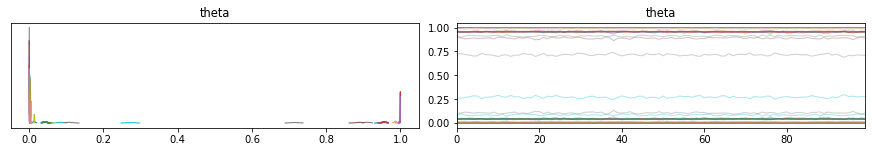

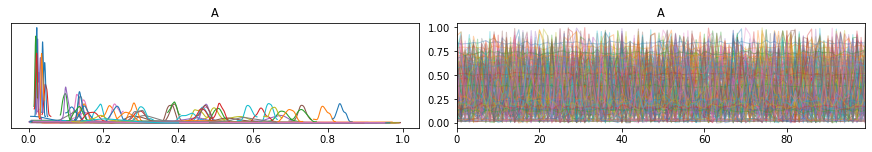

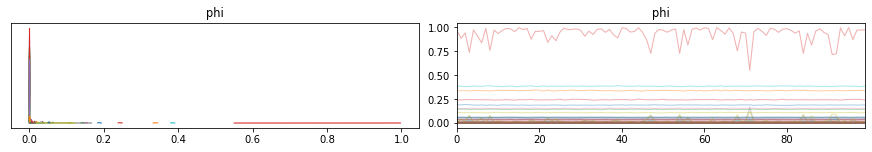

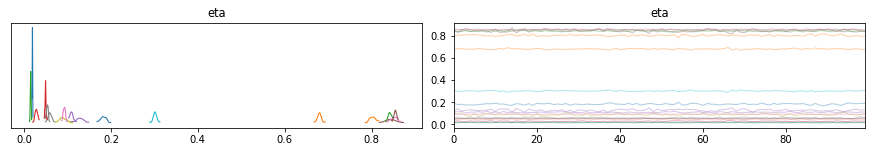

In [13]:
with model:
    pm.plot_trace(trace.approx.sample(100), var_names = 'theta');
    pm.plot_trace(trace.approx.sample(100), var_names = 'A');
    pm.plot_trace(trace.approx.sample(100), var_names = 'phi');
    pm.plot_trace(trace.approx.sample(100), var_names = 'eta');

In [26]:
plot_mean_std(np.einsum('sj,sjk->sjk', params['theta'], params['A']))

In [27]:
plot_mean_std(np.einsum('sj,sjk->sjk', hat.theta.mean(0), hat.A.mean(0)))

In [16]:
A =hat.A.mean((0))
#plot_bipartite((A[1].T/A[1].sum(1)).T, rescale =18, direction = 'back')
plot_bipartite_K(A[10])

In [17]:
A =hat.A.mean((0))
theta = hat.theta.mean(0)
plot_bipartite_K(theta[10]*A[10])

In [18]:
tau = get_tau(params['phi'], params['eta'])
plot_cossim(tau, get_tau(hat.phi.mean(0), hat.eta.mean(0)))

In [19]:
plot_cossim(params['phi'], hat.phi.mean(0))

In [20]:
def flatten_eta(eta): # eta pkm -> kc
    return np.moveaxis(eta,0,1).reshape(-1, 6)

print(flatten_eta(params['eta']).shape)
print(flatten_eta(hat.eta.mean(0)).shape)

(3, 6)
(3, 6)


In [21]:
plot_cossim(flatten_eta(params['eta']), flatten_eta(hat.eta.mean(0)))

In [22]:
plot_phi(phi).show()
plot_eta(eta).show()

In [23]:
plot_tau(get_tau(phi,eta)).show()


-----
val


In [24]:
print(alp_B(train, hat.B.mean(0)))
print(alp_B(val, hat.B.mean(0)))
print(alp_B(corpus, params['B']))
np.allclose(np.stack([train, val]).sum(0), corpus)
np.allclose((train + val), corpus)

-2.724944672287621
-2.7625847359169415
-2.7313821077528044


True

In [28]:
act = np.einsum('sj,sjk->sjk', params['theta'], params['A'])
plot_bipartite_J(act.mean(0)).show()
plot_bipartite_K(act.mean(0)).show()
plot_bipartite_J(act[1]).show()
plot_bipartite_K(act[1]).show()